In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import unicodedata
from underthesea import word_tokenize
from collections import Counter
from tqdm.notebook import tqdm  # Sử dụng tqdm.notebook cho Jupyter notebook
import sys
sys.path.append('/kaggle/input/lstm/pytorch/default/1/')
from main import *


## 1. Data Processing

In [3]:
df=pd.read_csv('/kaggle/input/vietnamese-sentiment-analyst/data.csv')
df.head(5)

,content,label,start
0,Áo bao đẹp ạ!,POS,5
1,Tuyệt vời,POS,5
2,2day ao khong giong trong,NEG,1
3,"Mùi thơm,bôi lên da mềm da",POS,5
4,"Vải đẹp, dày dặn",POS,5


In [4]:
df.shape

(31460, 3)

In [5]:
#keep only comment and label
df['comment']=df['content']
df = df[['comment', 'label']]
df.head(5)

,comment,label
0,Áo bao đẹp ạ!,POS
1,Tuyệt vời,POS
2,2day ao khong giong trong,NEG
3,"Mùi thơm,bôi lên da mềm da",POS
4,"Vải đẹp, dày dặn",POS


In [6]:
# remove null of comment and label
df = df.dropna(subset=['comment', 'label'])
df = df.drop_duplicates(subset=['comment', 'label'])
df.shape

(26810, 2)

In [7]:
# Cải tiến hàm clean_text
def enhanced_clean_text(text):
    # Normalize Vietnamese characters
    text = unicodedata.normalize('NFC', text)
    
    # Chuyển text sang lowercase
    text = text.lower()
    
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Xử lý emoji (có thể sử dụng thư viện emoji)
    # text = remove_emoji(text)  # Yêu cầu thư viện bổ sung
    
    # Xử lý dấu câu - giữ lại nếu có ý nghĩa hoặc loại bỏ
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Xử lý khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Word segmentation
    text = word_tokenize(text, format='text')
    
    # Loại bỏ stopwords (yêu cầu danh sách stopwords tiếng Việt)
    # text = remove_stopwords(text)  # Cần định nghĩa hàm này
    
    return text


def normalize_vietnamese(text):
    # Normalize Vietnamese characters
    text = unicodedata.normalize('NFC', text)
    return text

def word_segmentation(text):
    tokens = word_tokenize(text, format='text')
    return tokens

In [8]:
df['cleaned_text'] = df['comment'].apply(enhanced_clean_text)
df.head(5)

,comment,label,cleaned_text
0,Áo bao đẹp ạ!,POS,áo bao đẹp ạ
1,Tuyệt vời,POS,tuyệt_vời
2,2day ao khong giong trong,NEG,2 day ao khong_giong trong
3,"Mùi thơm,bôi lên da mềm da",POS,mùi thơm bôi lên da mềm da
4,"Vải đẹp, dày dặn",POS,vải đẹp dày dặn


In [9]:
df['cleaned_text'] = df['cleaned_text'].apply(normalize_vietnamese)
df.head(5)

,comment,label,cleaned_text
0,Áo bao đẹp ạ!,POS,áo bao đẹp ạ
1,Tuyệt vời,POS,tuyệt_vời
2,2day ao khong giong trong,NEG,2 day ao khong_giong trong
3,"Mùi thơm,bôi lên da mềm da",POS,mùi thơm bôi lên da mềm da
4,"Vải đẹp, dày dặn",POS,vải đẹp dày dặn


In [10]:
df['cleaned_text'] = df['cleaned_text'].apply(word_segmentation)
df.head(5)

,comment,label,cleaned_text
0,Áo bao đẹp ạ!,POS,áo bao đẹp ạ
1,Tuyệt vời,POS,tuyệt_vời
2,2day ao khong giong trong,NEG,2 day ao khong_giong trong
3,"Mùi thơm,bôi lên da mềm da",POS,mùi thơm bôi lên da mềm da
4,"Vải đẹp, dày dặn",POS,vải đẹp dày dặn


In [11]:
# map label
df['label'] = df['label'].map({'POS': 1, 'NEG': 0})
df = df.dropna(subset=['label'])
df.head(5)

,comment,label,cleaned_text
0,Áo bao đẹp ạ!,1.0,áo bao đẹp ạ
1,Tuyệt vời,1.0,tuyệt_vời
2,2day ao khong giong trong,0.0,2 day ao khong_giong trong
3,"Mùi thơm,bôi lên da mềm da",1.0,mùi thơm bôi lên da mềm da
4,"Vải đẹp, dày dặn",1.0,vải đẹp dày dặn


In [12]:
# Kiểm tra các giá trị unique trong label
print("Các giá trị unique trong label:", df['label'].unique())

# Kiểm tra xem có giá trị nào khác 0 và 1 không
non_binary_values = df[~df['label'].isin([0, 1])]
if len(non_binary_values) > 0:
    print(f"Có {len(non_binary_values)} mẫu có label khác 0 và 1:")
    print(non_binary_values[['comment', 'label']].head())
else:
    print("Không có giá trị label nào khác 0 và 1")

# Kiểm tra kiểu dữ liệu của label
print("Kiểu dữ liệu của cột label:", df['label'].dtype)

# Đếm số lượng cho mỗi nhãn
label_counts = df['label'].value_counts()
print("Số lượng mỗi giá trị label:")
print(label_counts)

Các giá trị unique trong label: [1. 0.]
Không có giá trị label nào khác 0 và 1
Kiểu dữ liệu của cột label: float64
Số lượng mỗi giá trị label:
label
1.0    16077
0.0     6353
Name: count, dtype: int64


## 2. Vectorization

In [13]:
def build_vocab(texts, max_size=50000):
    all_tokens = []
    for text in texts:
        tokens = text.split()
        all_tokens.extend(tokens)
    # count the frequency of each token
    word_counts = Counter(all_tokens)

    # add special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}

    # add the most common tokens to the vocab
    for word, count in word_counts.most_common(max_size - len(vocab)):
        vocab[word] = len(vocab)
    return vocab

def text_to_sequence(text, vocab):
    tokens = text.split()
    sequence = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return sequence

def pad_sequence(sequence, max_length):
    if len(sequence) < max_length:
        sequence += [0] * (max_length - len(sequence))
    else:
        sequence = sequence[:max_length]
    return sequence

In [14]:
# Build vocabulary from the cleaned text
vocab = build_vocab(df['cleaned_text'], max_size=50000)
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 10606


In [15]:
# transform the cleaned text to sequences
df['text_sequence'] = df['cleaned_text'].apply(lambda x: text_to_sequence(x, vocab))
df.head(5)

,comment,label,cleaned_text,text_sequence
0,Áo bao đẹp ạ!,1.0,áo bao đẹp ạ,"[9, 300, 3, 47]"
1,Tuyệt vời,1.0,tuyệt_vời,[11]
2,2day ao khong giong trong,0.0,2 day ao khong_giong trong,"[64, 765, 218, 2788, 85]"
3,"Mùi thơm,bôi lên da mềm da",1.0,mùi thơm bôi lên da mềm da,"[179, 287, 1701, 103, 239, 140, 239]"
4,"Vải đẹp, dày dặn",1.0,vải đẹp dày dặn,"[17, 3, 115, 219]"


In [16]:
# Thêm sau bước tạo text_sequence
# Kiểm tra số lượng sequence có độ dài bằng 0
empty_sequences = df[df['text_sequence'].apply(len) == 0]
print(f"Số mẫu có chuỗi rỗng: {len(empty_sequences)}")

if len(empty_sequences) > 0:
    print("Ví dụ một số mẫu có chuỗi rỗng:")
    print(empty_sequences[['comment', 'cleaned_text']].head())
    
    # Loại bỏ các mẫu có chuỗi rỗng
    df = df[df['text_sequence'].apply(len) > 0]
    print(f"Số mẫu còn lại sau khi lọc: {df.shape[0]}")

Số mẫu có chuỗi rỗng: 42
Ví dụ một số mẫu có chuỗi rỗng:
     comment cleaned_text
989        😌             
1003     😋😋😋             
1562      😍😍             
1872   😍😍😍😍😍             
2132    ❤❤👍😍             
Số mẫu còn lại sau khi lọc: 22388


In [17]:
# Kiểm tra độ dài sequence trước khi chia
df['seq_length'] = df['text_sequence'].apply(len)
print(f"Độ dài sequence nhỏ nhất: {df['seq_length'].min()}")
print(f"Độ dài sequence trung bình: {df['seq_length'].mean():.2f}")
print(f"Độ dài sequence lớn nhất: {df['seq_length'].max()}")

# Loại bỏ các sequence quá ngắn nếu cần
df = df[df['seq_length'] > 3]

Độ dài sequence nhỏ nhất: 1
Độ dài sequence trung bình: 9.25
Độ dài sequence lớn nhất: 72


In [18]:
def collate_fn(batch):
    # split the batch into texts and labels
    texts, labels = zip(*batch)
    
    # Kiểm tra và chuyển đổi labels
    labels_list = [float(label) for label in labels]  # Chuyển tất cả thành float trước
    
    # Chuyển thành tensor
    labels = torch.tensor(labels_list, dtype=torch.float)
    
    # get the length of each text
    lengths = torch.tensor([len(text) for text in texts])
    
    # pad the texts to the same length
    pad_sequence = torch.zeros((len(texts), lengths.max()), dtype=torch.long)
    for i, text in enumerate(texts):
        end = lengths[i]
        pad_sequence[i, :end] = torch.tensor(text[:end], dtype=torch.long)
    
    return pad_sequence, labels, lengths

In [19]:
df.shape

(18886, 5)

In [20]:
# split the data into train and test set
from sklearn.model_selection import train_test_split
train_sequences, tv_sequences, train_labels, tv_labels = train_test_split(
    df['text_sequence'].tolist(), 
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)
val_sequences,test_sequences,val_labels,test_labels=train_test_split(
    tv_sequences, 
    tv_labels,
    test_size=0.5,
    random_state=42
)


In [21]:
train_data = SentimentDataset(train_sequences, train_labels)
val_data=SentimentDataset(val_sequences, val_labels)
test_data = SentimentDataset(test_sequences, test_labels)

In [22]:
train_loader = DataLoader(train_data, 
                          batch_size=32, 
                          shuffle=True, 
                          collate_fn=collate_fn)
val_loader = DataLoader(test_data, 
                         batch_size=32, 
                         shuffle=True, 
                         collate_fn=collate_fn)
test_loader = DataLoader(test_data, 
                         batch_size=32, 
                         shuffle=False, 
                         collate_fn=collate_fn)

## 3. Model

In [23]:
# Khởi tạo model
model = RNN_model(
    vocab_size=len(vocab),
    embedding_dim=300,  # Kích thước embedding
    hidden_dim=256,     # Kích thước hidden state của LSTM
    n_layers=2,         # Số lớp LSTM
    output_dim=1,       # Output dimension (1 cho binary classification)
    dropout=0.3         # Tỷ lệ dropout
)

# Chuyển model sang GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Định nghĩa loss function và optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Hàm huấn luyện một epoch
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    # Thêm progress bar
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        # Lấy dữ liệu từ batch
        texts, labels, lengths = batch
        texts = texts.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(texts, lengths).squeeze(1)
        
        # Tính loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Tính accuracy
        predicted_labels = (predictions > 0.5).float()
        correct = (predicted_labels == labels).sum().item()
        correct_predictions += correct
        total_predictions += labels.shape[0]
        
        # Cập nhật loss và hiển thị trên progress bar
        batch_loss = loss.item()
        epoch_loss += batch_loss
        batch_acc = correct / labels.shape[0]
        
        # Cập nhật thông tin trên progress bar
        progress_bar.set_postfix({
            'loss': f'{batch_loss:.4f}',
            'acc': f'{batch_acc:.4f}'
        })
    
    # Tính accuracy trung bình
    accuracy = correct_predictions / total_predictions
    return epoch_loss / len(data_loader), accuracy


def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    # Thêm progress bar
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            # Lấy dữ liệu từ batch
            texts, labels, lengths = batch
            texts = texts.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            # Forward pass
            predictions = model(texts, lengths).squeeze(1)
            
            # Tính loss
            loss = criterion(predictions, labels)
            
            # Tính accuracy
            predicted_labels = (predictions > 0.5).float()
            correct = (predicted_labels == labels).sum().item()
            correct_predictions += correct
            total_predictions += labels.shape[0]
            
            # Cập nhật loss và hiển thị trên progress bar
            batch_loss = loss.item()
            epoch_loss += batch_loss
            batch_acc = correct / labels.shape[0]
            
            # Cập nhật thông tin trên progress bar
            progress_bar.set_postfix({
                'loss': f'{batch_loss:.4f}',
                'acc': f'{batch_acc:.4f}'
            })
    
    # Tính accuracy trung bình
    accuracy = correct_predictions / total_predictions
    return epoch_loss / len(data_loader), accuracy

In [25]:
# Train model
num_epochs = 10
best_val_loss = float('inf')

# Thêm progress bar cho epochs
epoch_progress = tqdm(range(num_epochs), desc="Epochs")
for epoch in epoch_progress:
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Lưu model tốt nhất
    if val_loss < best_val_loss:
        best_test_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    # Hiển thị thông tin trên progress bar
    epoch_progress.set_postfix({
        'train_loss': f'{train_loss:.4f}', 
        'train_acc': f'{train_acc:.4f}',
        'val_loss': f'{val_loss:.4f}', 
        'val_acc': f'{val_acc:.4f}'
    })
    
    # In thông tin chi tiết
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/10:
Train Loss: 0.3119, Train Acc: 0.8623
Validation Loss: 0.2826, Validation Acc: 0.8772


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2/10:
Train Loss: 0.2109, Train Acc: 0.9173
Validation Loss: 0.2683, Validation Acc: 0.8846


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/10:
Train Loss: 0.1497, Train Acc: 0.9449
Validation Loss: 0.3173, Validation Acc: 0.8904


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/10:
Train Loss: 0.1036, Train Acc: 0.9630
Validation Loss: 0.3319, Validation Acc: 0.8915


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/10:
Train Loss: 0.0673, Train Acc: 0.9778
Validation Loss: 0.4038, Validation Acc: 0.8947


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6/10:
Train Loss: 0.0472, Train Acc: 0.9846
Validation Loss: 0.4373, Validation Acc: 0.8909


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7/10:
Train Loss: 0.0305, Train Acc: 0.9902
Validation Loss: 0.5191, Validation Acc: 0.8872


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/10:
Train Loss: 0.0319, Train Acc: 0.9902
Validation Loss: 0.5553, Validation Acc: 0.8872


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 9/10:
Train Loss: 0.0231, Train Acc: 0.9925
Validation Loss: 0.6235, Validation Acc: 0.8788


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10/10:
Train Loss: 0.0209, Train Acc: 0.9923
Validation Loss: 0.6569, Validation Acc: 0.8867


## 4. Evalute

In [26]:
# Load model tốt nhất
model.load_state_dict(torch.load('best_model.pt'))

# Đánh giá trên tập test
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Hàm dự đoán với văn bản mới
def predict_sentiment(text, model, vocab):
    # Làm sạch text
    cleaned_text = enhanced_clean_text(text)
    cleaned_text = normalize_vietnamese(cleaned_text)
    cleaned_text = word_segmentation(cleaned_text)
    
    # Chuyển text thành sequence
    sequence = text_to_sequence(cleaned_text, vocab)
    
    # Chuyển sequence thành tensor
    sequence_tensor = torch.LongTensor([sequence]).to(device)
    length_tensor = torch.LongTensor([len(sequence)]).to(device)
    
    # Dự đoán
    model.eval()
    with torch.no_grad():
        prediction = model(sequence_tensor, length_tensor).item()
    
    # Phân loại
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return sentiment, prediction

# Ví dụ dự đoán
sample_text = "Sản phẩm rất tốt và giá cả hợp lý"
sentiment, confidence = predict_sentiment(sample_text, model, vocab)
print(f'Text: "{sample_text}"')
print(f'Sentiment: {sentiment}, Confidence: {confidence:.4f}')

/tmp/ipykernel_13/3985642040.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.6569, Test Acc: 0.8867
Text: "Sản phẩm rất tốt và giá cả hợp lý"
Sentiment: Positive, Confidence: 1.0000


### Confusion Matrix

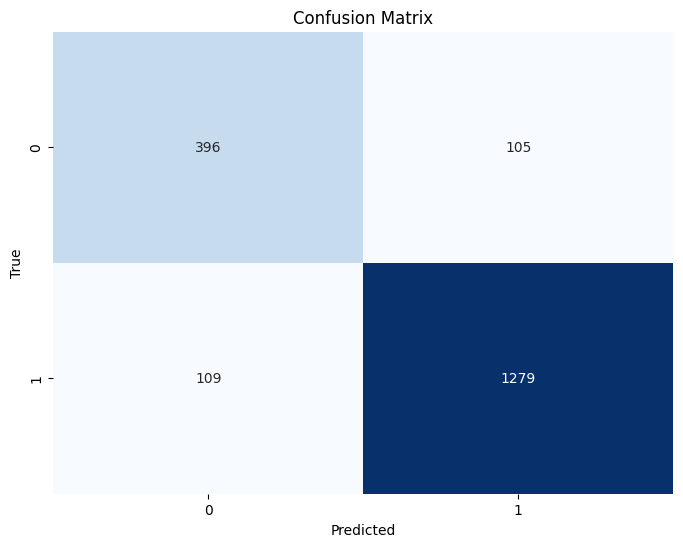

In [27]:
# Import các thư viện cần thiết
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thu thập tất cả dự đoán và nhãn thật từ tập test
def get_predictions(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Collecting predictions"):
            texts, labels, lengths = batch
            texts = texts.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            # Dự đoán
            predictions = model(texts, lengths).squeeze(1)
            
            # Lưu kết quả
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Lấy tất cả dự đoán và nhãn thật
print("Collecting predictions from test set...")
y_pred_proba, y_true = get_predictions(model, test_loader, device)
y_pred = (y_pred_proba > 0.5).astype(int)

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Classification Report

In [28]:

# 2. Classification Report
report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79       501
    Positive       0.92      0.92      0.92      1388

    accuracy                           0.89      1889
   macro avg       0.85      0.86      0.86      1889
weighted avg       0.89      0.89      0.89      1889



### ROC Curve

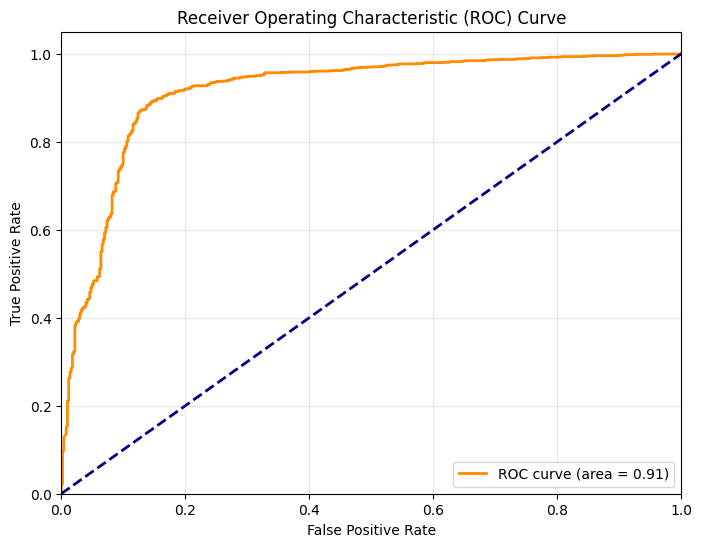

In [29]:
# 3. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()



### Precision-Recall Curve

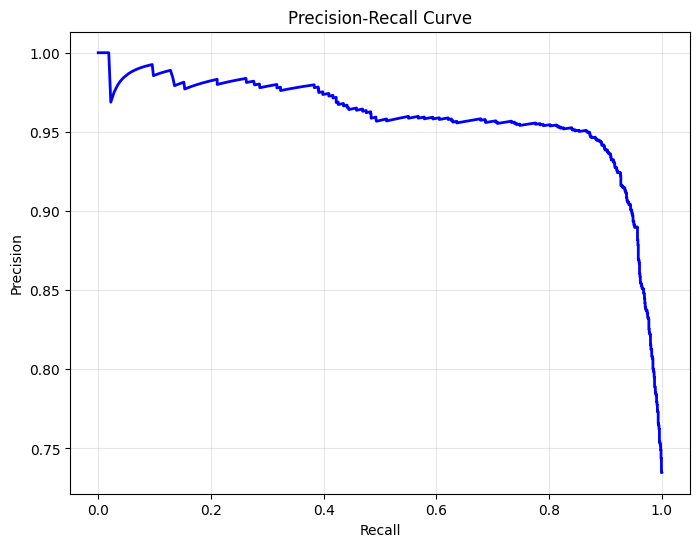

In [30]:
# 4. Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()


### Histogram của confidence scores

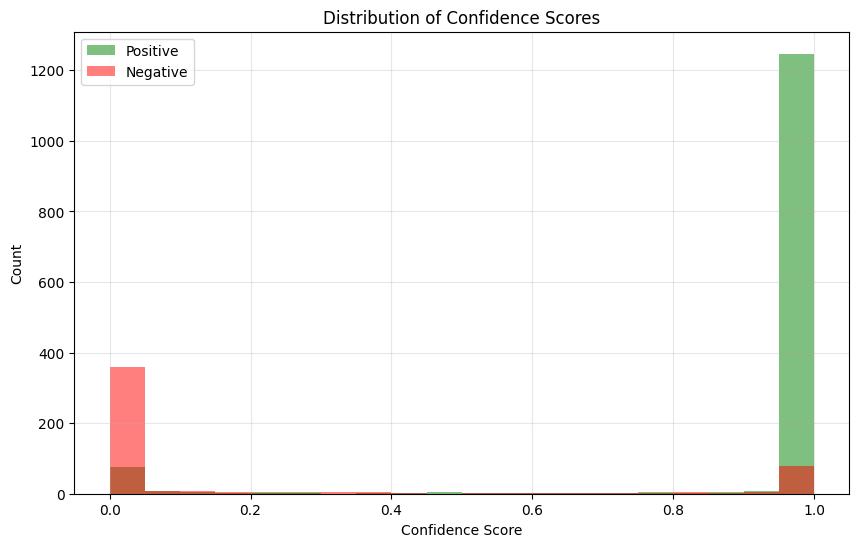

In [31]:

# 5. Histogram của confidence scores
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_true == 1], alpha=0.5, bins=20, label='Positive', color='green')
plt.hist(y_pred_proba[y_true == 0], alpha=0.5, bins=20, label='Negative', color='red')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Distribution of Confidence Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Phân tích lỗi: Các mẫu được phân loại sai với confidence cao

In [32]:
# Phân tích lỗi: Các mẫu được phân loại sai với confidence cao
def analyze_misclassifications(test_texts, true_labels, pred_probs, n_samples=5):
    pred_labels = (pred_probs > 0.5).astype(int)
    misclassified = []
    
    for i in range(len(test_texts)):
        if pred_labels[i] != true_labels[i]:
            confidence = pred_probs[i] if pred_labels[i] == 1 else 1 - pred_probs[i]
            misclassified.append((test_texts[i], true_labels[i], pred_probs[i], confidence))
    
    # Sắp xếp theo confidence (từ cao đến thấp)
    misclassified.sort(key=lambda x: x[3], reverse=True)
    
    return misclassified[:n_samples]

# Chuyển test_sequences thành text để dễ đọc
test_df = pd.DataFrame({
    'text_sequence': test_sequences,
    'true_label': test_labels
})

# Lấy text gốc
test_texts = df.iloc[test_df.index]['comment'].tolist()

# Tìm các mẫu bị phân loại sai với confidence cao
misclassified_samples = analyze_misclassifications(test_texts, y_true, y_pred_proba)

print("\nTop 5 mẫu bị phân loại sai với confidence cao nhất:")
for i, (text, true_label, pred_prob, confidence) in enumerate(misclassified_samples):
    print(f"Mẫu {i+1}:")
    print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
    print(f"Nhãn thật: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Dự đoán: {'Positive' if pred_prob > 0.5 else 'Negative'} (confidence: {confidence:.4f})")
    print("-" * 80)


Top 5 mẫu bị phân loại sai với confidence cao nhất:
Mẫu 1:
Text: Khi nhận hàng thì lúc đầu bạn sẽ nghĩ "omg thật tuyệt" nhưng sau khi soi kĩ thì sản phẩm không giống...
Nhãn thật: Positive
Dự đoán: Negative (confidence: 1.0000)
--------------------------------------------------------------------------------
Mẫu 2:
Text: Áo đẹp dã man luôn,shop tư vấn nhiệt tình
Nhãn thật: Negative
Dự đoán: Positive (confidence: 1.0000)
--------------------------------------------------------------------------------
Mẫu 3:
Text: Màu sắc k giống hình
Nhãn thật: Negative
Dự đoán: Positive (confidence: 1.0000)
--------------------------------------------------------------------------------
Mẫu 4:
Text: Chất áo nóng và không đẹp áo k giống hình Rất không đáng tiền
Nhãn thật: Negative
Dự đoán: Positive (confidence: 1.0000)
--------------------------------------------------------------------------------
Mẫu 5:
Text: Thích hợp để khoác hơn là mặt, chị chủ dễ thương lắm luôn nè 😍
Nhãn thật: Negative
Dự đoán: P

### Save Model

In [33]:
# Lưu model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab': vocab
}, 'sentiment_model_full.pt')

# Tải model
def load_model(path):
    vocab_size = len(vocab)
    loaded_model = RNN_model(
        vocab_size=vocab_size,
        embedding_dim=300,
        hidden_dim=256,
        n_layers=2,
        output_dim=1,
        dropout=0.3
    )
    
    checkpoint = torch.load(path)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    return loaded_model, checkpoint['vocab']

# Sử dụng model đã load
loaded_model, loaded_vocab = load_model('sentiment_model_full.pt')
loaded_model = loaded_model.to(device)

# Dự đoán với model đã load
sentiment, confidence = predict_sentiment(sample_text, loaded_model, loaded_vocab)
print(f'Sentiment (loaded model): {sentiment}, Confidence: {confidence:.4f}')

Sentiment (loaded model): Positive, Confidence: 1.0000


/tmp/ipykernel_13/170709103.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)
